In [1]:
from msmbuilder.example_datasets import MullerPotential
from msmbuilder.preprocessing import MinMaxScaler
%matplotlib inline
from __future__ import print_function, division
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np


import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from utils import *



/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead

In [2]:
trajs = MullerPotential().get().trajectories

In [3]:
sc = MinMaxScaler(feature_range=(-1 , 1))
sc.fit(trajs)

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [4]:
txx = np.concatenate(trajs)

In [5]:
a = sc.fit_transform([txx])[0]

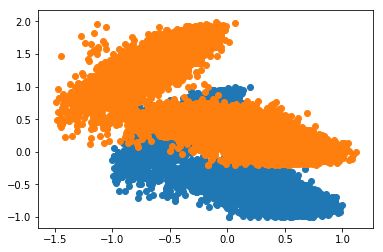

In [6]:
ax = scatter(a)
scatter(txx, ax=ax)

In [7]:
train, test = train_test_split(a)

In [8]:
train.shape

(75000, 2)

In [9]:
test.shape

(25000, 2)

In [10]:

make_latent_samples(1, 100) # generates one sample



array([[ 1.43355612e-01,  3.94694367e-01, -1.41709423e-01,
         7.66912286e-01,  5.08343946e-01,  3.08738017e-01,
         1.07426313e+00,  5.08004453e-01, -1.37221668e+00,
        -5.55336869e-01, -1.06114018e+00,  1.23461336e+00,
         1.34541581e+00, -2.92463308e-01, -5.56089427e-02,
         9.08328191e-01, -1.81747241e-01, -2.78970279e-01,
         1.02158805e+00,  1.16192436e+00,  7.03359607e-01,
         1.07462055e-03, -4.72164531e-01,  3.92164529e-01,
         5.21112697e-01,  4.07926551e-01, -5.85932089e-01,
         1.67794051e-01,  2.81389610e-01,  4.05291687e-01,
         8.06907245e-01,  1.47535054e-01,  3.00030904e-01,
         1.45620748e+00, -1.08178803e+00, -4.15576823e-01,
        -1.26307541e+00, -8.43292568e-01,  4.21450612e+00,
         1.02665318e+00,  1.50674606e-01,  1.43289921e+00,
        -2.54673259e-01,  4.82911968e-01, -3.39433483e-01,
        -4.03757452e-03, -1.08016379e-01,  1.06352063e+00,
        -9.82343102e-01, -1.53148920e+00, -1.54620916e-0

In [11]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size   = 128
d_hidden_size   = 128
leaky_alpha     = 0.01
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 100
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

In [13]:
y_eval_real

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [14]:
# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_2dtraj_GAN(
    sample_size, 
    g_hidden_size, 
    d_hidden_size, 
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)

In [15]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [16]:
test

array([[-0.25302227,  0.40644241],
       [ 0.69642728, -0.83685729],
       [-0.09870602,  0.63316361],
       ...,
       [-0.74132897,  0.0503772 ],
       [-0.35616628,  0.38339919],
       [-0.14329459,  0.61328613]])

In [17]:
losses = []
for e in range(epochs):
    for i in range(len(train)//batch_size):
        # real x y coords
        X_batch_real = train[i*batch_size:(i+1)*batch_size]
        

        # latent samples and the generated x y coords
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)
        
        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
        
        
    # evaluate
    X_eval_real = test[np.random.choice(len(test), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))

/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/100 Discriminator Loss: 0.9941 Generator Loss: 1.1476
Epoch:   2/100 Discriminator Loss: 0.9933 Generator Loss: 1.1991
Epoch:   3/100 Discriminator Loss: 1.2541 Generator Loss: 0.8986
Epoch:   4/100 Discriminator Loss: 1.2476 Generator Loss: 0.8771
Epoch:   5/100 Discriminator Loss: 1.3937 Generator Loss: 0.8026
Epoch:   6/100 Discriminator Loss: 1.3151 Generator Loss: 0.8253
Epoch:   7/100 Discriminator Loss: 1.3521 Generator Loss: 0.8122
Epoch:   8/100 Discriminator Loss: 1.2572 Generator Loss: 0.8885
Epoch:   9/100 Discriminator Loss: 1.4035 Generator Loss: 0.7815
Epoch:  10/100 Discriminator Loss: 1.3382 Generator Loss: 0.7781
Epoch:  11/100 Discriminator Loss: 1.2382 Generator Loss: 0.8809
Epoch:  12/100 Discriminator Loss: 1.3815 Generator Loss: 0.8317
Epoch:  13/100 Discriminator Loss: 1.2778 Generator Loss: 0.8039
Epoch:  14/100 Discriminator Loss: 1.3257 Generator Loss: 0.8603
Epoch:  15/100 Discriminator Loss: 1.3076 Generator Loss: 0.8346
Epoch:  16/100 Discrimina

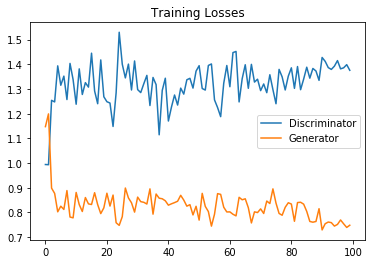

In [18]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()
fig.savefig('ayy.png')

In [19]:
latent_samples = make_latent_samples(50000, sample_size)
generated_coords = generator.predict(latent_samples)

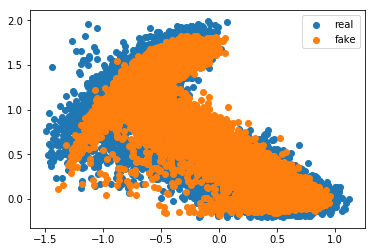

In [24]:
f, ax = plt.subplots()
ax = scatter(txx, scatter_kws={'label':'real'}, ax=ax)
scatter(sc.inverse_transform(generated_coords), ax, {'label':'fake'})
ax.legend()
f.savefig('first_test.png')